Training set size: 3530
Validation set size: 801
Test set size: 638
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

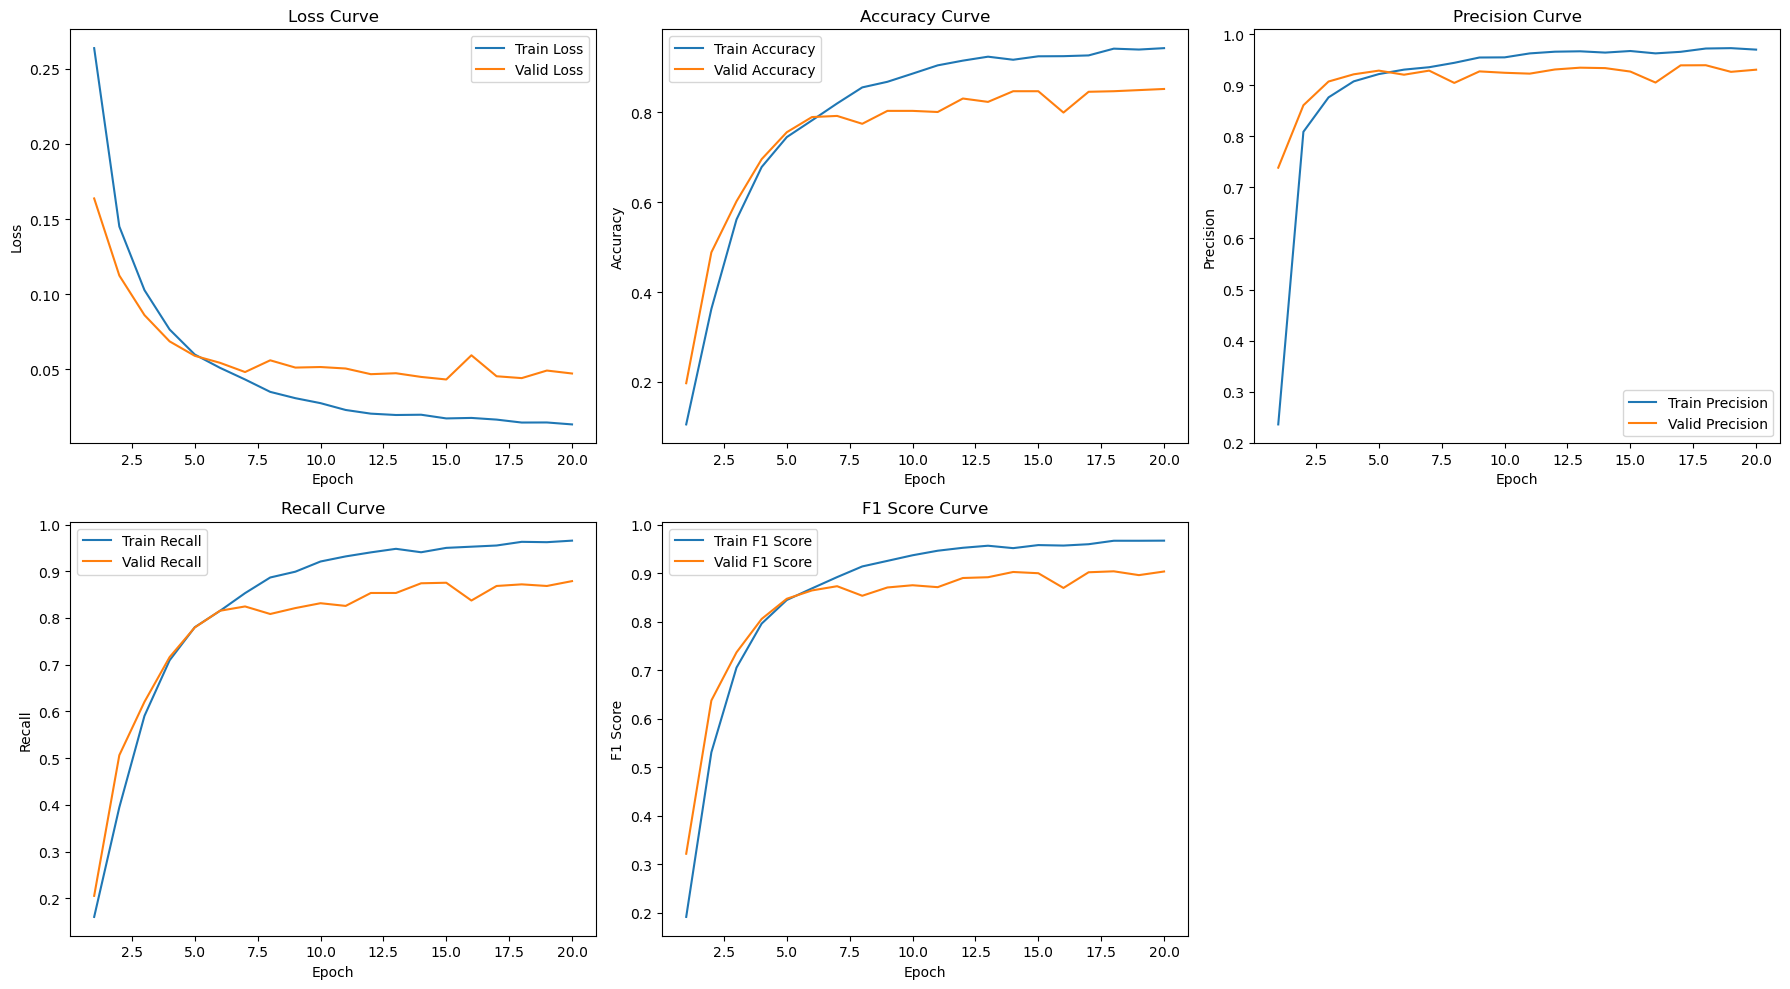

/var/folders/wz/0c7bfp356ll9s67twzcqkv340000gn/T/ipykernel_32299/1646211461.py:451: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('R_best_mo


Performance across different thresholds:

Threshold = 0.3:
Accuracy:       0.8182
Precision:      0.8987
Recall:         0.8743
F1 Score:       0.8863
Hamming Loss:   0.0164
Subset Accuracy:0.8182

Threshold = 0.4:
Accuracy:       0.8197
Precision:      0.9177
Recall:         0.8600
F1 Score:       0.8879
Hamming Loss:   0.0159
Subset Accuracy:0.8197

Threshold = 0.5:
Accuracy:       0.8135
Precision:      0.9266
Recall:         0.8471
F1 Score:       0.8851
Hamming Loss:   0.0161
Subset Accuracy:0.8135

Threshold = 0.6:
Accuracy:       0.8056
Precision:      0.9313
Recall:         0.8329
F1 Score:       0.8793
Hamming Loss:   0.0167
Subset Accuracy:0.8056

Threshold = 0.7:
Accuracy:       0.7837
Precision:      0.9419
Recall:         0.8100
F1 Score:       0.8710
Hamming Loss:   0.0176
Subset Accuracy:0.7837

Best threshold: 0.4 with F1 Score: 0.8879


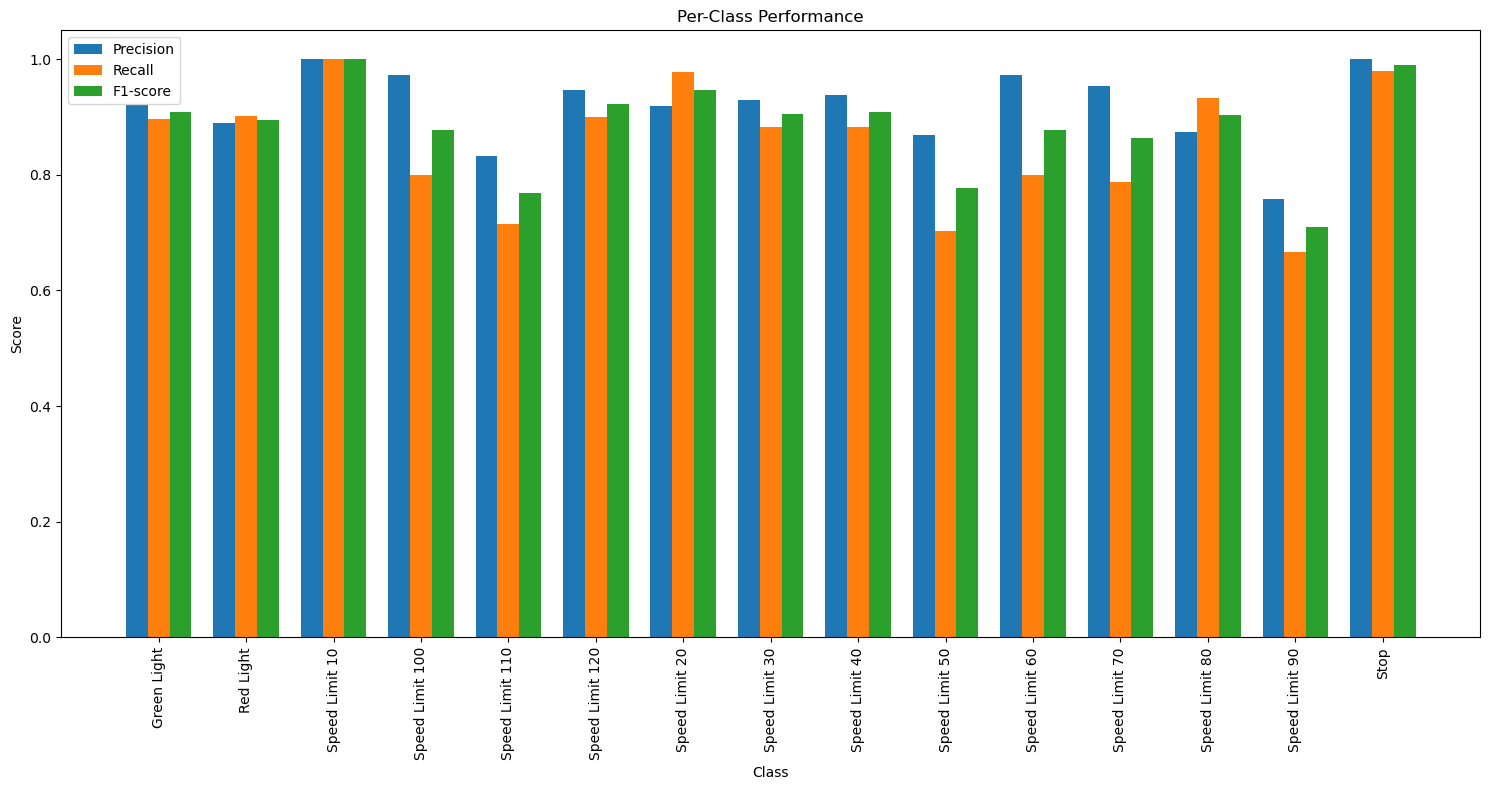


Performance on multi-label images:
Accuracy:       0.5283
Precision:      0.9663
Recall:         0.7414
F1 Score:       0.8390
Hamming Loss:   0.0415
Subset Accuracy:0.5283

Performance on single-label images:
Accuracy:       0.8476
Precision:      0.9117
Recall:         0.8836
F1 Score:       0.8974
Hamming Loss:   0.0135
Subset Accuracy:0.8476
Evaluation complete. Results saved to R_test_results.txt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34, ResNet34_Weights
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, hamming_loss

# Use Dataloader to load data
data_path = "traffic_sign_detection/car_resized"

subfolders = ["train", "test", "valid"]

# define transforms 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(20),  # rotate
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # brightness
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # affine
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ]), 
    
    'eval': transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])
}

class ImageLabelDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.num_classes = 15

        # sort : keep the order
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        label_path = os.path.join(self.label_dir, image_file.replace('.jpg', '.txt'))

        image = Image.open(image_path).convert('RGB')
        label = torch.zeros(self.num_classes)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    tokens = line.strip().split()
                    if not tokens:
                        continue
                    try:
                        class_id = int(tokens[0])
                        if 0 <= class_id < self.num_classes:
                            label[class_id] = 1
                    except ValueError:
                        continue

        if self.transform:
            image = self.transform(image)
            
        return image, label

datasets = []

for name in subfolders:
    image_dir = os.path.join(data_path, name, "images")
    label_dir = os.path.join(data_path, name, "labels")

    if name == "train":
        transform = data_transforms['train']
    else:
        transform = data_transforms['eval']

    datasets.append(ImageLabelDataset(image_dir, label_dir, transform=transform))

train_dataset, test_dataset, valid_dataset = datasets

batch = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")

train_size = len(train_dataset)
valid_size = len(valid_dataset)
test_size = len(test_dataset)

# model init
model = resnet34(weights=ResNet34_Weights.DEFAULT)
num_classes = 15

# change fc's output size to 15
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, num_classes)
)

# freeze all first
for param in model.parameters():
    param.requires_grad = False

# unfreeze 2\3\4\fc
for name, param in model.named_parameters():
    if "layer2" in name or "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True

print(model)
# model info
input_size = (3, 224, 224)
summary(model, input_size=input_size)

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)

# use different lr for layers
optimizer = optim.Adam([
    {"params": model.layer2.parameters(), "lr": 1e-5},
    {"params": model.layer3.parameters(), "lr": 5e-5},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 5e-4}
], weight_decay=1e-4)

# loss
criterion = nn.BCEWithLogitsLoss()

# lr scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Firstly based on F1
    factor=0.5,  # divided by 2
    patience=3,  # wait 3 times if no progress
    verbose=True
)

def plot_metrics(train_losses, valid_losses, train_metrics, valid_metrics):
    """绘制多个指标的训练曲线"""
    epochs = range(1, len(train_losses) + 1)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    plt.figure(figsize=(18, 10))
    
    # loss curves
    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, valid_losses, label="Valid Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # metric curves
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+2) 
        plt.plot(epochs, [m[i] for m in train_metrics], label=f"Train {metric}")
        plt.plot(epochs, [m[i] for m in valid_metrics], label=f"Valid {metric}")
        plt.title(f"{metric} Curve")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig("R_training_metrics.png")
    plt.show()

def calculate_metrics(all_labels, all_preds, threshold=0.5):
    """计算多个评估指标"""
    # binary
    binary_preds = (all_preds > threshold).astype(float)
    
    # metric computing
    accuracy = accuracy_score(all_labels, binary_preds)
    precision = precision_score(all_labels, binary_preds, average='micro', zero_division=0)
    recall = recall_score(all_labels, binary_preds, average='micro', zero_division=0)
    f1 = f1_score(all_labels, binary_preds, average='micro')
    
    # metrics for each class
    class_precision = precision_score(all_labels, binary_preds, average=None, zero_division=0)
    class_recall = recall_score(all_labels, binary_preds, average=None, zero_division=0)
    class_f1 = f1_score(all_labels, binary_preds, average=None, zero_division=0)
    
    # metrics for multi-label
    hamming = hamming_loss(all_labels, binary_preds)
    subset_acc = accuracy_score(all_labels, binary_preds, normalize=True)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'class_precision': class_precision,
        'class_recall': class_recall,
        'class_f1': class_f1,
        'hamming_loss': hamming,
        'subset_accuracy': subset_acc
    }

def print_metrics(metrics, epoch=None, phase=None):
    """打印评估指标"""
    if epoch is not None and phase is not None:
        print(f"\nEpoch {epoch} - {phase} Metrics:")
    
    print(f"Accuracy:       {metrics['accuracy']:.4f}")
    print(f"Precision:      {metrics['precision']:.4f}")
    print(f"Recall:         {metrics['recall']:.4f}")
    print(f"F1 Score:       {metrics['f1']:.4f}")
    print(f"Hamming Loss:   {metrics['hamming_loss']:.4f}")
    print(f"Subset Accuracy:{metrics['subset_accuracy']:.4f}")

def train(model, criterion, optimizer, scheduler, train_dataloader, valid_dataloader, 
          num_epochs=30, threshold=0.5):
    """训练模型"""
    device = next(model.parameters()).device
    best_f1 = 0.0
    
    train_losses, valid_losses = [], []
    train_metrics_history, valid_metrics_history = [], []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 50)
        
        # train
        model.train()
        running_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            
            all_train_labels.append(labels.cpu().numpy())
            all_train_preds.append(torch.sigmoid(outputs).detach().cpu().numpy())
        
        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)
        
        all_train_labels = np.vstack(all_train_labels)
        all_train_preds = np.vstack(all_train_preds)
        
        train_metrics = calculate_metrics(all_train_labels, all_train_preds, threshold)
        train_metrics_list = [train_metrics['accuracy'], train_metrics['precision'], 
                             train_metrics['recall'], train_metrics['f1']]
        train_metrics_history.append(train_metrics_list)
        
        print(f"Train Loss: {epoch_loss:.4f}")
        print_metrics(train_metrics, epoch+1, "Train")
        
        # valid
        model.eval()
        running_loss = 0.0
        all_valid_labels = []
        all_valid_preds = []
        
        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                
                all_valid_labels.append(labels.cpu().numpy())
                all_valid_preds.append(torch.sigmoid(outputs).cpu().numpy())
        
        epoch_loss = running_loss / len(valid_dataset)
        valid_losses.append(epoch_loss)
        
        all_valid_labels = np.vstack(all_valid_labels)
        all_valid_preds = np.vstack(all_valid_preds)
        
        valid_metrics = calculate_metrics(all_valid_labels, all_valid_preds, threshold)
        valid_metrics_list = [valid_metrics['accuracy'], valid_metrics['precision'], 
                             valid_metrics['recall'], valid_metrics['f1']]
        valid_metrics_history.append(valid_metrics_list)
        
        print(f"Valid Loss: {epoch_loss:.4f}")
        print_metrics(valid_metrics, epoch+1, "Valid")
        
        
        scheduler.step(valid_metrics['f1'])
        
        # save best model
        if valid_metrics['f1'] > best_f1:
            best_f1 = valid_metrics['f1']
            torch.save(model.state_dict(), 'R_best_model.pt')
            print(f"Best model saved with F1: {best_f1:.4f}")
        
        # print metrics
        if (epoch + 1) % 5 == 0:  # each 5 epochs
            class_names = ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 
                          'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 
                          'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 
                          'Speed Limit 80', 'Speed Limit 90', 'Stop']
            
            print("\nClass-wise Performance:")
            for i, name in enumerate(class_names):
                print(f"{name}: Precision={valid_metrics['class_precision'][i]:.4f}, "
                      f"Recall={valid_metrics['class_recall'][i]:.4f}, "
                      f"F1={valid_metrics['class_f1'][i]:.4f}")
    
    # call plot function
    plot_metrics(train_losses, valid_losses, train_metrics_history, valid_metrics_history)
    
    return model

def evaluate_model(model, dataloader, threshold=0.5):
    """在测试集上评估模型"""
    device = next(model.parameters()).device
    model.eval()
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            
            all_labels.append(labels.numpy())
            all_preds.append(probs.cpu().numpy())
    
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)
    
    # try different treshold?
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
    print("\nPerformance across different thresholds:")
    
    best_threshold = 0.5
    best_f1 = 0
    
    for t in thresholds:
        metrics = calculate_metrics(all_labels, all_preds, t)
        print(f"\nThreshold = {t}:")
        print_metrics(metrics)
        
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = t
    
    print(f"\nBest threshold: {best_threshold} with F1 Score: {best_f1:.4f}")
    
    # use the best treshold
    metrics = calculate_metrics(all_labels, all_preds, best_threshold)
    
    # plot the performance for each class
    class_names = ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 
                  'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 
                  'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 
                  'Speed Limit 80', 'Speed Limit 90', 'Stop']
    
    plt.figure(figsize=(15, 8))
    x = np.arange(len(class_names))
    width = 0.25
    
    plt.bar(x - width, metrics['class_precision'], width, label='Precision')
    plt.bar(x, metrics['class_recall'], width, label='Recall')
    plt.bar(x + width, metrics['class_f1'], width, label='F1-score')
    
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Per-Class Performance')
    plt.xticks(x, class_names, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig('R_class_performance.png')
    plt.show()
    
    # analysis multi-label performence
    multi_label_indices = np.where(np.sum(all_labels, axis=1) > 1)[0]
    single_label_indices = np.where(np.sum(all_labels, axis=1) == 1)[0]
    
    if len(multi_label_indices) > 0:
        multi_metrics = calculate_metrics(
            all_labels[multi_label_indices], 
            all_preds[multi_label_indices], 
            best_threshold
        )
        print("\nPerformance on multi-label images:")
        print_metrics(multi_metrics)
    
    if len(single_label_indices) > 0:
        single_metrics = calculate_metrics(
            all_labels[single_label_indices], 
            all_preds[single_label_indices], 
            best_threshold
        )
        print("\nPerformance on single-label images:")
        print_metrics(single_metrics)
    
    return metrics

# train
trained_model = train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_dataloader,
    valid_dataloader,
    num_epochs=20,  # 训练轮次
    threshold=0.5
)

# use model to test
model.load_state_dict(torch.load('R_best_model.pt'))
test_metrics = evaluate_model(model, test_dataloader)

# save the result
with open('R_test_results.txt', 'w') as f:
    f.write("ResNet34 Test Results (Partial Unfreeze)\n")
    f.write("---------------------------------\n")
    f.write(f"Accuracy:        {test_metrics['accuracy']:.4f}\n")
    f.write(f"Precision:       {test_metrics['precision']:.4f}\n")
    f.write(f"Recall:          {test_metrics['recall']:.4f}\n")
    f.write(f"F1 Score:        {test_metrics['f1']:.4f}\n")
    f.write(f"Hamming Loss:    {test_metrics['hamming_loss']:.4f}\n")
    f.write(f"Subset Accuracy: {test_metrics['subset_accuracy']:.4f}\n")
    
    # for class
    f.write("\nPer-Class Results:\n")
    class_names = ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 
                  'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 
                  'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 
                  'Speed Limit 80', 'Speed Limit 90', 'Stop']
    
    for i, name in enumerate(class_names):
        f.write(f"{name}: Precision={test_metrics['class_precision'][i]:.4f}, ")
        f.write(f"Recall={test_metrics['class_recall'][i]:.4f}, ")
        f.write(f"F1={test_metrics['class_f1'][i]:.4f}\n")

print("Evaluation complete. Results saved to R_test_results.txt")